In [1]:
from transformers import PreTrainedTokenizerFast,GPT2LMHeadModel
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [2]:
import numpy as np
import pandas as pd
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.core.lightning import LightningModule
from torch.utils.data import DataLoader, Dataset
from transformers.optimization import AdamW, get_cosine_schedule_with_warmup
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel
import re

In [3]:
data = pd.read_csv('../prep_data_dotsplits.csv')
DEVICE =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
data.dropna(inplace=True)
data.rename(columns={'본문':'Q','답변':'A'}, inplace=True)

In [4]:
Q_TKN = "<usr>"
A_TKN = "<sys>"
BOS = '</s>'
EOS = '</s>'
MASK = '<mask>'
SENT = '<sent>'
PAD = '<pad>'

In [5]:
class ChatbotDataset(Dataset):
    def __init__(self, chats, max_len=40):  # 데이터셋의 전처리를 해주는 부분
        self._data = chats
        self.max_len = max_len
        self.q_token = Q_TKN
        self.a_token = A_TKN
        self.sent_token = SENT
        self.eos = EOS
        self.mask = MASK
        self.tokenizer = tokenizer

    def __len__(self):  # chatbotdata 의 길이를 리턴한다.
        return len(self._data)

    def __getitem__(self, idx):  # 로드한 챗봇 데이터를 차례차례 DataLoader로 넘겨주는 메서드
        turn = self._data.iloc[idx]
        q = turn["Q"]  # 질문을 가져온다.
        q = re.sub(r"([?.!,])", r" ", q)  # 구둣점들을 제거한다.

        a = turn["A"]  # 답변을 가져온다.
        a = re.sub(r"([?.!,])", r" ", a)  # 구둣점들을 제거한다.

        q_toked = self.tokenizer.tokenize(self.q_token + q + self.sent_token)
        q_len = len(q_toked)

        a_toked = self.tokenizer.tokenize(self.a_token + a + self.eos)
        a_len = len(a_toked)

        #질문의 길이가 최대길이보다 크면
        if q_len > self.max_len:
            a_len = self.max_len - q_len        #답변의 길이를 최대길이 - 질문길이
            if a_len <= 0:       #질문의 길이가 너무 길어 질문만으로 최대 길이를 초과 한다면
                q_toked = q_toked[-(int(self.max_len / 2)) :]   #질문길이를 최대길이의 반으로 
                q_len = len(q_toked)
                a_len = self.max_len - q_len              #답변의 길이를 최대길이 - 질문길이
            a_toked = a_toked[:a_len]
            a_len = len(a_toked)

        #질문의 길이 + 답변의 길이가 최대길이보다 크면
        if q_len + a_len > self.max_len:
            a_len = self.max_len - q_len        #답변의 길이를 최대길이 - 질문길이
            if a_len <= 0:       #질문의 길이가 너무 길어 질문만으로 최대 길이를 초과 한다면
                q_toked = q_toked[-(int(self.max_len / 2)) :]   #질문길이를 최대길이의 반으로 
                q_len = len(q_toked)
                a_len = self.max_len - q_len              #답변의 길이를 최대길이 - 질문길이
            a_toked = a_toked[:a_len]
            a_len = len(a_toked)

        # 답변 labels = [mask, mask, ...., mask, ..., <bos>,..답변.. <eos>, <pad>....]
        labels = [self.mask,] * q_len + a_toked[1:]

        # mask = 질문길이 0 + 답변길이 1 + 나머지 0
        mask = [0] * q_len + [1] * a_len + [0] * (self.max_len - q_len - a_len)
        # 답변 labels을 index 로 만든다.
        labels_ids = self.tokenizer.convert_tokens_to_ids(labels)
        # 최대길이만큼 PADDING
        while len(labels_ids) < self.max_len:
            labels_ids += [self.tokenizer.pad_token_id]

        # 질문 + 답변을 index 로 만든다.    
        token_ids = self.tokenizer.convert_tokens_to_ids(q_toked + a_toked)
        # 최대길이만큼 PADDING
        while len(token_ids) < self.max_len:
            token_ids += [self.tokenizer.pad_token_id]

        #질문+답변, 마스크, 답변
        return (token_ids, np.array(mask), labels_ids)

In [6]:
def collate_batch(batch):
    data = [item[0] for item in batch]
    mask = [item[1] for item in batch]
    label = [item[2] for item in batch]
    return torch.LongTensor(data), torch.LongTensor(mask), torch.LongTensor(label)

In [7]:
train_set = ChatbotDataset(data, max_len=512)
#윈도우 환경에서 num_workers 는 무조건 0으로 지정, 리눅스에서는 2
train_dataloader = DataLoader(train_set, batch_size=2, num_workers=0, pin_memory=True,shuffle=True, collate_fn=collate_batch)

In [34]:
print("start")
for batch_idx, samples in enumerate(train_dataloader):
    token_ids, mask, label = samples
    print("token_ids ====> ", token_ids)
    print("mask =====> ", mask)
    print("label =====> ", label)
print("end")

start
token_ids ====>  tensor([[    2,  9043, 10936,  ...,     3,     3,     3],
        [    2,  9074,  6826,  ...,     3,     3,     3]])
mask =====>  tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
label =====>  tensor([[6, 6, 6,  ..., 3, 3, 3],
        [6, 6, 6,  ..., 3, 3, 3]])
token_ids ====>  tensor([[    2,  9265,  8806,  ...,     3,     3,     3],
        [    2, 45887, 24433,  ..., 27250,  9028,  8270]])
mask =====>  tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1]])
label =====>  tensor([[   6,    6,    6,  ...,    3,    3,    3],
        [   6,    6,    6,  ..., 9028, 8270,    3]])
token_ids ====>  tensor([[    2, 16312, 12517,  ...,  8262,  7489, 10038],
        [    2, 36752, 24433,  ..., 46253, 14830, 36348]])
mask =====>  tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])
label =====>  tensor([[    6,     6,     6,  ...,  7489, 10038,     3],
        [    6,     6,     6,  ..., 14830, 36348,     3]])
token_ids ===

KeyboardInterrupt: 

In [8]:
model.to(DEVICE) 

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [9]:
learning_rate = 3e-5
criterion = torch.nn.CrossEntropyLoss(reduction="none")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch = 10
Sneg = -1e18

In [10]:
from tqdm import tqdm
model.train()
print ("start")
for epoch in tqdm(range(epoch)):
    for batch_idx, samples in enumerate(train_dataloader):
        optimizer.zero_grad()
        token_ids, mask, label = samples
        token_ids = token_ids.cuda(non_blocking=True)
        mask = mask.cuda(non_blocking=True)
        label = label.cuda(non_blocking=True)
        out = model(token_ids)
        out = out.logits      #Returns a new tensor with the logit of the elements of input
        mask_3d = mask.unsqueeze(dim=2).repeat_interleave(repeats=out.shape[2], dim=2)
        mask_out = torch.where(mask_3d == 1, out, Sneg * torch.ones_like(out))
        loss = criterion(mask_out.transpose(2, 1), label)
        # 평균 loss 만들기 avg_loss[0] / avg_loss[1] <- loss 정규화
        avg_loss = loss.sum() / mask.sum()
        avg_loss.backward()
        # 학습 끝
        optimizer.step()
        if batch_idx % 10 == 9:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {batch_idx + 1:5d}] loss: {avg_loss / 2000:.3f}')
            avg_loss = 0.0
print ("end")

start


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\lucky\AppData\Local\Temp\ipykernel_8636\2495599640.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  return torch.LongTensor(data), torch.LongTensor(mask), torch.LongTensor(label)


[1,    10] loss: 0.008
[1,    20] loss: 0.051
[1,    30] loss: 0.006
[1,    40] loss: 0.022
[1,    50] loss: 0.020
[1,    60] loss: 0.013
[1,    70] loss: 0.005
[1,    80] loss: 0.002
[1,    90] loss: 0.030
[1,   100] loss: 0.007
[1,   110] loss: 0.006
[1,   120] loss: 0.051
[1,   130] loss: 0.038
[1,   140] loss: 0.006
[1,   150] loss: 0.006
[1,   160] loss: 0.004
[1,   170] loss: 0.003
[1,   180] loss: 0.004
[1,   190] loss: 0.017
[1,   200] loss: 0.019
[1,   210] loss: 0.021
[1,   220] loss: 0.010
[1,   230] loss: 0.021
[1,   240] loss: 0.049
[1,   250] loss: 0.028
[1,   260] loss: 0.017
[1,   270] loss: 0.007
[1,   280] loss: 0.025
[1,   290] loss: 0.019
[1,   300] loss: 0.022
[1,   310] loss: 0.006
[1,   320] loss: 0.032
[1,   330] loss: 0.007
[1,   340] loss: 0.031
[1,   350] loss: 0.033
[1,   360] loss: 0.007
[1,   370] loss: 0.014
[1,   380] loss: 0.004
[1,   390] loss: 0.057
[1,   400] loss: 0.065
[1,   410] loss: 0.027
[1,   420] loss: 0.032
[1,   430] loss: 0.022
[1,   440] 

 10%|█         | 1/10 [43:58<6:35:44, 2638.32s/it]

[2,    10] loss: 0.022
[2,    20] loss: 0.022
[2,    30] loss: 0.013
[2,    40] loss: 0.006
[2,    50] loss: 0.017
[2,    60] loss: 0.005
[2,    70] loss: 0.007
[2,    80] loss: 0.041
[2,    90] loss: 0.006
[2,   100] loss: 0.030
[2,   110] loss: 0.002
[2,   120] loss: 0.033
[2,   130] loss: 0.043
[2,   140] loss: 0.015
[2,   150] loss: 0.021
[2,   160] loss: 0.018
[2,   170] loss: 0.006
[2,   180] loss: 0.006
[2,   190] loss: 0.020
[2,   200] loss: 0.018
[2,   210] loss: 0.008
[2,   220] loss: 0.028
[2,   230] loss: 0.083
[2,   240] loss: 0.012
[2,   250] loss: 0.005
[2,   260] loss: 0.010
[2,   270] loss: 0.004
[2,   280] loss: 0.032
[2,   290] loss: 0.003
[2,   300] loss: 0.013
[2,   310] loss: 0.010
[2,   320] loss: 0.026
[2,   330] loss: 0.039
[2,   340] loss: 0.028
[2,   350] loss: 0.017
[2,   360] loss: 0.009
[2,   370] loss: 0.009
[2,   380] loss: 0.013
[2,   390] loss: 0.014
[2,   400] loss: 0.012
[2,   410] loss: 0.020
[2,   420] loss: 0.015
[2,   430] loss: 0.050
[2,   440] 

 10%|█         | 1/10 [54:18<8:08:49, 3258.82s/it]


KeyboardInterrupt: 

In [21]:
with torch.no_grad():
    while 1:
        q = input("user > ").strip()
        if q == "quit":
            break
        a = ""
        while 1:
            input_ids = torch.LongTensor(tokenizer.encode(Q_TKN + q + A_TKN + a)).unsqueeze(dim=0).to(DEVICE)
            pred = model(input_ids)
            pred = pred.logits.to('cpu')
            gen = tokenizer.convert_ids_to_tokens(torch.argmax(pred, dim=-1).squeeze().numpy().tolist())[-1]
            if gen == EOS:
                break
            a += gen.replace("▁", " ")
        print("Chatbot > {}".format(a.strip()))

Chatbot > 고소의 취하는 고소인이 할 수 있는 행위인바 고소인은 고소인이 될 수 있는 경우이거나 고소인이 고소가 취하될 수 있습니다
Chatbot > 차량의 경우 현재 점유자가 원하는 때에 한하여 그 자동차의 현재 점유자가 소유자가 원하는 때에 한하여 그 자동차의 현재 점유자가 원하는 때에 자동차를 인도받을 수 있습니다  그 인도받을 수 있는 차량이 현재 점유자인 아버지를 상대로 민사소송 제기된 경우라면 채무자 질문자의 아버지께서 그 자동차를 자기가 소유하게 된 경위를 알지 못한다면 채무자 질문자의 아버지께서 그 자동차를 타게 되면 질문자가 그 자동차를 자신의 소유로 하여 자동차를 인도받을 수 있게 됩니다


In [14]:
data['Q'][0]

'정말 어려운 상황에서 너무나도 힘들어서 질문을 드립니다. 부디 자세한 설명해주시면 감사하겠습니다. 아버지가 제 명의로 사업자를 내서 사업을 했으나 늘어나는 것은 빛뿐이었습니다. 더 이상은 방관할 수가 없어 아버지에게 제 명의로 해드린 것을 모두 정지시키려고 하는 상황입니다. 또 어머니 명의의 집을 팔아서 빚을 메꾸려고 합니다. 첫 번째 질문입니다. 어머니 명의로 된 집 아버지 어머니 함께 거주를 매도하려고 하는데 그 과정에서 아버지가 방해를 하고 가구 이동을 못 시키게 하고 그러면 어떤 방법을 취할 수 있을까요 두 번째 질문입니다. 제 명의로 된 차량을 아버지가 사용하고 계셨는데 제가 도로 갖고 와도 될까요. 아니면 어떤 방법이 있을까요 답변해 주시면 정말 감사드리겠습니다'

In [15]:
data['A'][0]

'차량의 경우 현재 점유자인 아버지를 피고로 하여 차량 인도 청구소송 및 차량 점유 이전금지 가처분으로 차량을 조기에 회수할 수 있습니다'

데이터의 최대 길이 : 6203
데이터의 최소 길이 : 13
데이터의 평균 길이 : 411.682557


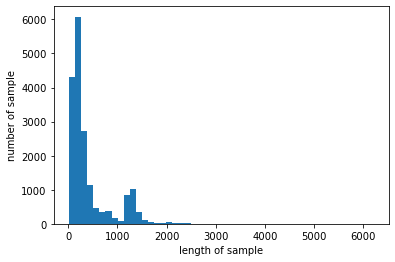

In [4]:
import matplotlib.pyplot as plt
max_len = max(len(l) for l in data)
print('데이터의 최대 길이 : %d' % max_len)
print('데이터의 최소 길이 : %d' % min(len(l) for l in data))
print('데이터의 평균 길이 : %f' % (sum(map(len, data))/len(data)))
plt.hist([len(s) for s in data], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()